In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt 
from ultralytics import YOLO

feature_maps = {}
gradients = {}

def save_feature_maps(module, input, output):
    """Forward hook to capture the Activations."""

    feature_maps["A"] = output.detach() 

def save_gradients(module, grad_input, grad_output):
    """Backward hook to capture the Gradients (∂Yc/∂Ak)."""

    gradients["grads"] = grad_output[0].detach() 


In [2]:
def grad_cam_pp_yolo(model, target_layer, input_tensor):
    """
    Calculates the Grad-CAM++ heatmap in YOLOv8.
    
    Args:
        model (nn.Module): The model.
        target_layer (nn.Module): The convolutional layer to target.
        input_tensor (torch.Tensor): Input image (Batch x C x H x W).    
    Returns:
        np.ndarray: The heatmap.
    """
    forward_handle = target_layer.register_forward_hook(save_feature_maps)
    backward_handle = target_layer.register_full_backward_hook(save_gradients)

    input_tensor.requires_grad_(True) 
    output = model(input_tensor)
    target_score_tensor = output[0][0, 0, 4] 
    model.zero_grad()
    target_score_tensor.backward(retain_graph=True) 

    A = feature_maps["A"]
    grads = gradients["grads"]

    forward_handle.remove()
    backward_handle.remove()

    A = A.squeeze(0)
    grads = grads.squeeze(0)
    
    g_1 = grads.clamp(min=0) 
    numerator = g_1.pow(2)
    A_sum = A.sum(dim=(1, 2), keepdim=True)
    denominator = 2 * g_1.pow(2) + A_sum * g_1.pow(3)

    # Avoid division by zero
    denominator = torch.where(
        denominator != 0.0, denominator, torch.ones_like(denominator)
    )
    alpha_ij_kc = numerator / denominator
    W_k_c = (alpha_ij_kc * g_1).sum(dim=(1, 2), keepdim=True) 
    L_Grad_CAM_c = (W_k_c * A).sum(dim=0) 
    L_Grad_CAM_c = torch.relu(L_Grad_CAM_c).detach().cpu().numpy()
    L_Grad_CAM_c = L_Grad_CAM_c / L_Grad_CAM_c.max()
    heatmap = cv2.resize(L_Grad_CAM_c, (input_tensor.shape[3], input_tensor.shape[2]))

    return heatmap

In [3]:
yolo_model = YOLO("yolov8n.pt") 
model = yolo_model.model.to("cpu").eval() 
target_layer = model.model[9] 

img_path = "data\elephant.jpg" 
img = Image.open(img_path).convert("RGB")
IMG_SIZE = 640 

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
input_tensor = preprocess(img).unsqueeze(0)

heatmap_pp = grad_cam_pp_yolo(model, target_layer, input_tensor)
results = yolo_model.predict(img_path, imgsz=IMG_SIZE, verbose=False)

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
C:\Users\LAY\AppData\Local\Temp\ipykernel_9484\3073756393.py:5: SyntaxWarning: invalid escape sequence '\e'
  img_path = "data\elephant.jpg"


In [4]:
def unnormalize_img(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Convert a normalized tensor back to an image (numpy array)."""
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    image = tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).detach().numpy() 
    return (image * 255).astype(np.uint8)

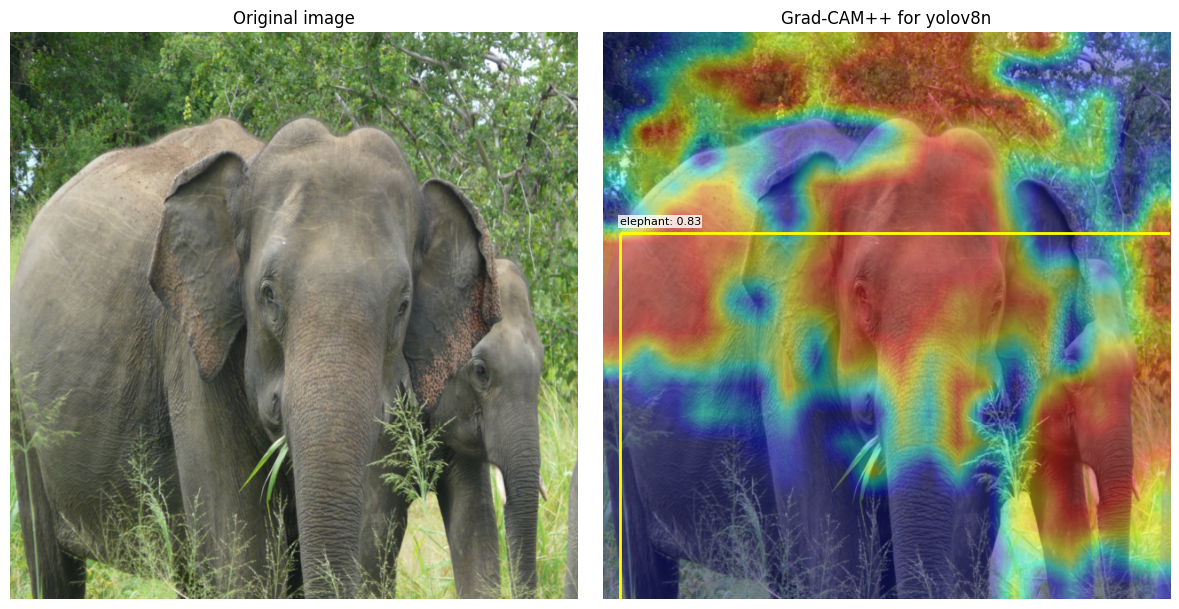

In [11]:
unnormalized_img = unnormalize_img(input_tensor)

heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_pp), cv2.COLORMAP_JET)
heatmap_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

alpha = 0.4
img_np_float = unnormalized_img.astype(np.float32)
heatmap_rgb_float = heatmap_rgb.astype(np.float32)
superimposed_img = np.uint8((1 - alpha) * img_np_float + alpha * heatmap_rgb_float)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(unnormalized_img)
ax[0].set_title("Original image")
ax[0].axis('off')
ax[1].imshow(superimposed_img)
ax[1].set_title('Grad-CAM++ for yolov8n')
ax[1].axis('off') 

if results and len(results[0].boxes):
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    names = yolo_model.names 
    for box, score, classe in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                             fill=False, edgecolor='yellow', linewidth=2)
        ax[1].add_patch(rect)
        label = f'{names[int(classe)]}: {score:.2f}'
        ax[1].text(x1, y1 - 10, label, color='black', 
                   fontsize=8, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))
        
plt.tight_layout()
plt.show()